In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
test = pd.read_excel('https://github.com/akhrameevmd/Analiz_dannyh_2020/blob/main/test1.xlsx?raw=true')
train = pd.read_excel('https://github.com/akhrameevmd/Analiz_dannyh_2020/blob/main/train1.xlsx?raw=true')
random.seed = 1

### Выкидываем ненужные переменные

In [3]:
train.drop(['N','rand'],axis=1,inplace=True)
test.drop(['N'],axis=1,inplace=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CreditStatus           629 non-null    int64  
 1   CheckingAcctStat       629 non-null    object 
 2   Duration               629 non-null    float64
 3   CreditHistory          629 non-null    object 
 4   Purpose                629 non-null    object 
 5   CreditAmount           629 non-null    float64
 6   Savings                629 non-null    object 
 7   Employment             629 non-null    object 
 8   InstallmentRatePecnt   629 non-null    float64
 9   SexAndStatus           629 non-null    object 
 10  OtherDetorsGuarantors  629 non-null    object 
 11  PresentResidenceTime   629 non-null    float64
 12  Property               629 non-null    object 
 13  Age                    629 non-null    float64
 14  OtherInstalments       629 non-null    object 
 15  Housin

### Кодируем категориальные переменные, после чего обновляем трейновый и тестовый датасеты в соответствии с кодированием

In [5]:
cat = ['CheckingAcctStat', 'CreditHistory', 'Purpose', 'Savings', 'Employment', 'SexAndStatus', 'OtherDetorsGuarantors',
       'Property', 'OtherInstalments', 'Housing', 'Job', 'Telephone', 'ForeignWorker']
ohe = OneHotEncoder(drop='first')

In [6]:
ohe.fit(train[cat])
onehotlabels = ohe.transform(train[cat]).toarray()
train = pd.concat([train.drop(cat,axis=1),pd.DataFrame(onehotlabels)],axis=1)

In [7]:
ohelabels = ohe.transform(test[cat]).toarray()
test = pd.concat([test.drop(cat,axis=1),pd.DataFrame(ohelabels)],axis=1)

### Разбиваем трейновый датасет на тест и трейн чтобы подобрать наилучшую модель, исходя из предположения что датасет test мы не видим

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('CreditStatus',1),train.CreditStatus,test_size=0.25)

# Тестируем разные подходы

# RandomForestClassifier

In [9]:
grid = {'n_estimators':[100,200,500],
       'max_depth':np.arange(2,10),
       'criterion':['gini','entropy']}
RF = RandomForestClassifier()
cvRF = GridSearchCV(RF,grid,n_jobs=-1,scoring='roc_auc',cv=7)

In [10]:
cvRF.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [100, 200, 500]},
             scoring='roc_auc')

In [11]:
cvRF.best_params_

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}

In [12]:
cvRF.score(X_test,y_test)

0.8724963361016121

# XGBClassifier

In [13]:
xgb = XGBClassifier()
grid = {'max_depth':np.arange(1,10),
         'learning_rate':[0.01,0.1,0.2]}
cvXGB = GridSearchCV(xgb,grid,n_jobs=-1,scoring='roc_auc',cv=7)

In [14]:
cvXGB.fit(X_train,y_train);

[18:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Conda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [15]:
cvXGB.best_params_

{'learning_rate': 0.2, 'max_depth': 4}

In [16]:
cvXGB.score(X_test,y_test)

0.89057156814851

# SVM

In [17]:
SVM = SVC()
grid = {'C': [0.001, 0.01, 0.1, 1, 10, 20, 30, 100],
       'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
cvSVM = GridSearchCV(SVM,grid,n_jobs=-1,scoring='roc_auc',cv=7)

In [18]:
cvSVM.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 20, 30, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc')

In [19]:
cvSVM.best_params_

{'C': 10, 'kernel': 'rbf'}

In [20]:
cvSVM.score(X_test,y_test)

0.8109428431851489

# LogisticRegression

In [21]:
LR = LogisticRegression()
grid = {'penalty':['l1','l2','elasticnet'],
        'C': [0.01, 0.1, 1]}
cvLR = GridSearchCV(LR,grid,n_jobs=-1,scoring='roc_auc',cv=7)

In [22]:
cvLR.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc')

In [23]:
cvLR.best_params_

{'C': 1, 'penalty': 'l2'}

In [24]:
cvLR.score(X_test,y_test)

0.7855398143624819

### Лучше всего себя показал RF, обучим его на всей выборке и протестируем на test

In [25]:
grid = {'n_estimators':[100,200,500],
       'max_depth':np.arange(2,10),
       'criterion':['gini','entropy']}
RF = RandomForestClassifier()
cvRF = GridSearchCV(RF,grid,n_jobs=-1,scoring='roc_auc',cv=7)

In [26]:
cvRF.fit(train.drop('CreditStatus',1),train.CreditStatus)

GridSearchCV(cv=7, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [100, 200, 500]},
             scoring='roc_auc')

In [27]:
cvRF.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}

In [28]:
cvRF.score(test.drop('CreditStatus',axis=1),test.CreditStatus)

0.8980492610837438

In [29]:
X_train = train.drop('CreditStatus',1)
y_train = train.CreditStatus
X_test = test.drop('CreditStatus',axis=1)
y_test = test.CreditStatus

### Построим ROC кривую

In [30]:
bestRF = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=9)

In [31]:
bestRF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=9)

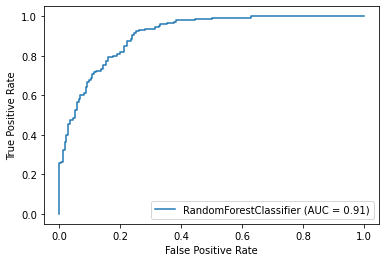

In [32]:
plot_roc_curve(bestRF, X_test, y_test);